In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn import cluster, datasets
from pandas import DataFrame as df
from IPython.display import clear_output

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
import RBF, WhiteKernel, ConstantKernel as C
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve

from gp_extras.kernels import ManifoldKernel

%matplotlib inline
#%matplotlib qt
%config InlineBackend.figure_format = 'retina'

In [2]:
def import_data():
    dataset = pd.read_csv('../data/DP.csv',usecols=[27],engine='python',skipfooter=None)
    return dataset
def mean_absolute_percentage_error(y_true, y_pred): 

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


def prepareInputs(daydata, season, UsedInputs):
    nbrInputs= 0
    
    previousHours = UsedInputs[0]
    previousDay = UsedInputs[1]
    previousWeek = UsedInputs[2]
    temp = UsedInputs[3]
    tempMax = UsedInputs[4]
    tempMin = UsedInputs[5]
    dayIndicator = UsedInputs[6]
    
    if previousHours == True: nbrInputs= nbrInputs+ 1
    if previousDay == True: nbrInputs= nbrInputs+1
    if previousWeek == True : nbrInputs= nbrInputs+ 1
    if temp == True: nbrInputs= nbrInputs+1
    if tempMax == True: nbrInputs= nbrInputs+1
    if tempMin == True: nbrInputs= nbrInputs+1
    if dayIndicator== True: nbrInputs= nbrInputs+7

    hourclusters= np.empty([(daydata.index.size*24),1])

    hourdataindex= pd.DataFrame(index=pd.date_range('2014-1-8 00:00:00', periods=(365)*24, freq='H'))

    for x in range(0,daydata.index.size):
        for y in range(0,24):
            hourclusters[(x * 24) + y,0] = daydata.iloc[x,24]
    hourclusters.size

    tempAlgiers=  pd.read_csv('../data/tempAlgiers.csv')
    tempA= tempAlgiers.loc[:,'Hour_1':'Hour_24']
    tempnp= np.array(tempA)
    tempnp= tempnp.reshape(-1,1)
    tempdata= pd.DataFrame(tempnp)

    tempmax= tempAlgiers.loc[:,'Tmax']
    tempmin= tempAlgiers.loc[:,'Tmin']




    tempmx= np.random.random([tempmax.size*24,1])
    tempmn= np.random.random([tempmin.size*24,1])



    for x in range(0,tempmax.size):
        for y in range(0,24):
            tempmx[(x * 24) + y,0] = tempmax.iloc[x]

    for x in range(0,tempmin.size):
        for y in range(0,24):
            tempmn[(x * 24) + y,0] = tempmin.iloc[x]
        

    samples = daydata.index.size*24
    daydata2= daydata.copy()
    del(daydata2['cluster'])

    data= pd.DataFrame(np.array(daydata2).reshape(-1,1))

    maxcons= data.values.max()
    mincons= data.values.min()

    maxtemp= np.max(tempdata.values)
    mintemp= tempdata.values.min()

    maxtempmax= np.max(tempmx)
    mintempmax= np.min(tempmx)

    maxtempmin= np.max(tempmn)
    mintempmin= np.min(tempmn)

    sigxx= np.empty((samples - 168 , nbrInputs))
    sigyy= np.empty((samples - 168 , 1))

    i= 0
    for x in list(range(168,samples)):
        i=0
        if previousHours == True: 
            sigxx[x - 168 , i] = (data.iloc[x - 1 , 0])/(2*maxcons)
            i= i+ 1
        if previousDay == True: 
            sigxx[x - 168 , i] = (data.iloc[x - 24 , 0])/(2*maxcons)
            i= i+1
        if previousWeek == True : 
            sigxx[x - 168 , i] = (data.iloc[x - 168 , 0])/(2*maxcons)
            i= i+ 1
        if temp == True: 
            sigxx[x - 168 , i] = (tempdata.iloc[x])/(2*maxtemp)
            i= i+1
        if tempMax == True: 
            sigxx[x - 168 , i] = (tempmx[x])/(2*maxtempmax)
            i= i+1
        if tempMin == True: 
            sigxx[x - 168 , i] = (tempmn[x])/(2*maxtempmin)
            i= i+1
        if dayIndicator == True:
            ind=0
            for y in range(0,7):
                sigxx[x - 168 , i+ind]= 0
                ind = ind + 1
            sigxx[x - 168 , i+pd.datetime.weekday(hourdataindex.index[x])]=1

    
    for x in list(range(168,samples)):
        sigyy[x - 168 , 0]= (data.iloc[x , 0])/(2*maxcons)

    sigmoidxx= df(sigxx.copy())
    sigmoidyy= df(sigyy.copy())

    sigmoidxx.index= pd.date_range('2014-1-8 00:00:00', periods=(365-7)*24, freq='H')
    sigmoidyy.index= pd.date_range('2014-1-8 00:00:00', periods=(365-7)*24, freq='H')

    sigmoidxx['cluster'] = hourclusters[168:]
    sigmoidyy['cluster'] = hourclusters[168:]
    dfhourclusters = df(hourclusters)
    
    SigmoidInputs =sigmoidxx[sigmoidxx.cluster==season].copy()
    
    SigmoidOutputs= sigmoidyy[sigmoidyy.cluster==SigmoidInputs.loc[SigmoidInputs.index[0],'cluster']]
    del(SigmoidInputs['cluster'],SigmoidOutputs['cluster'])
    
    learningoutputs = pd.DataFrame(SigmoidOutputs.iloc[:int(SigmoidOutputs.size-168)].values.copy(),
                            index=SigmoidOutputs.iloc[:int(SigmoidOutputs.size-168)].index)
    testoutputs = pd.DataFrame(SigmoidOutputs.iloc[int(SigmoidOutputs.size-168):].values.copy(),
                            index=SigmoidOutputs.iloc[int(SigmoidOutputs.size-168):].index)

    learninginputs = pd.DataFrame(SigmoidInputs.iloc[:int(SigmoidOutputs.size-168)].values.copy(),
                            index=SigmoidOutputs.iloc[:int(SigmoidOutputs.size-168)].index)
    testinputs = pd.DataFrame(SigmoidInputs.iloc[int(SigmoidOutputs.size-168):].values.copy(),
                            index=SigmoidOutputs.iloc[int(SigmoidOutputs.size-168):].index)

    print('-------Input preparation process complet-------')
    return learninginputs, learningoutputs, testinputs, testoutputs, nbrInputs

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  4.  0.  0.  0.  0.  0.  0.  0.  4.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  4.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  4.  4.  4.  1.  1.  4.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  4.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2

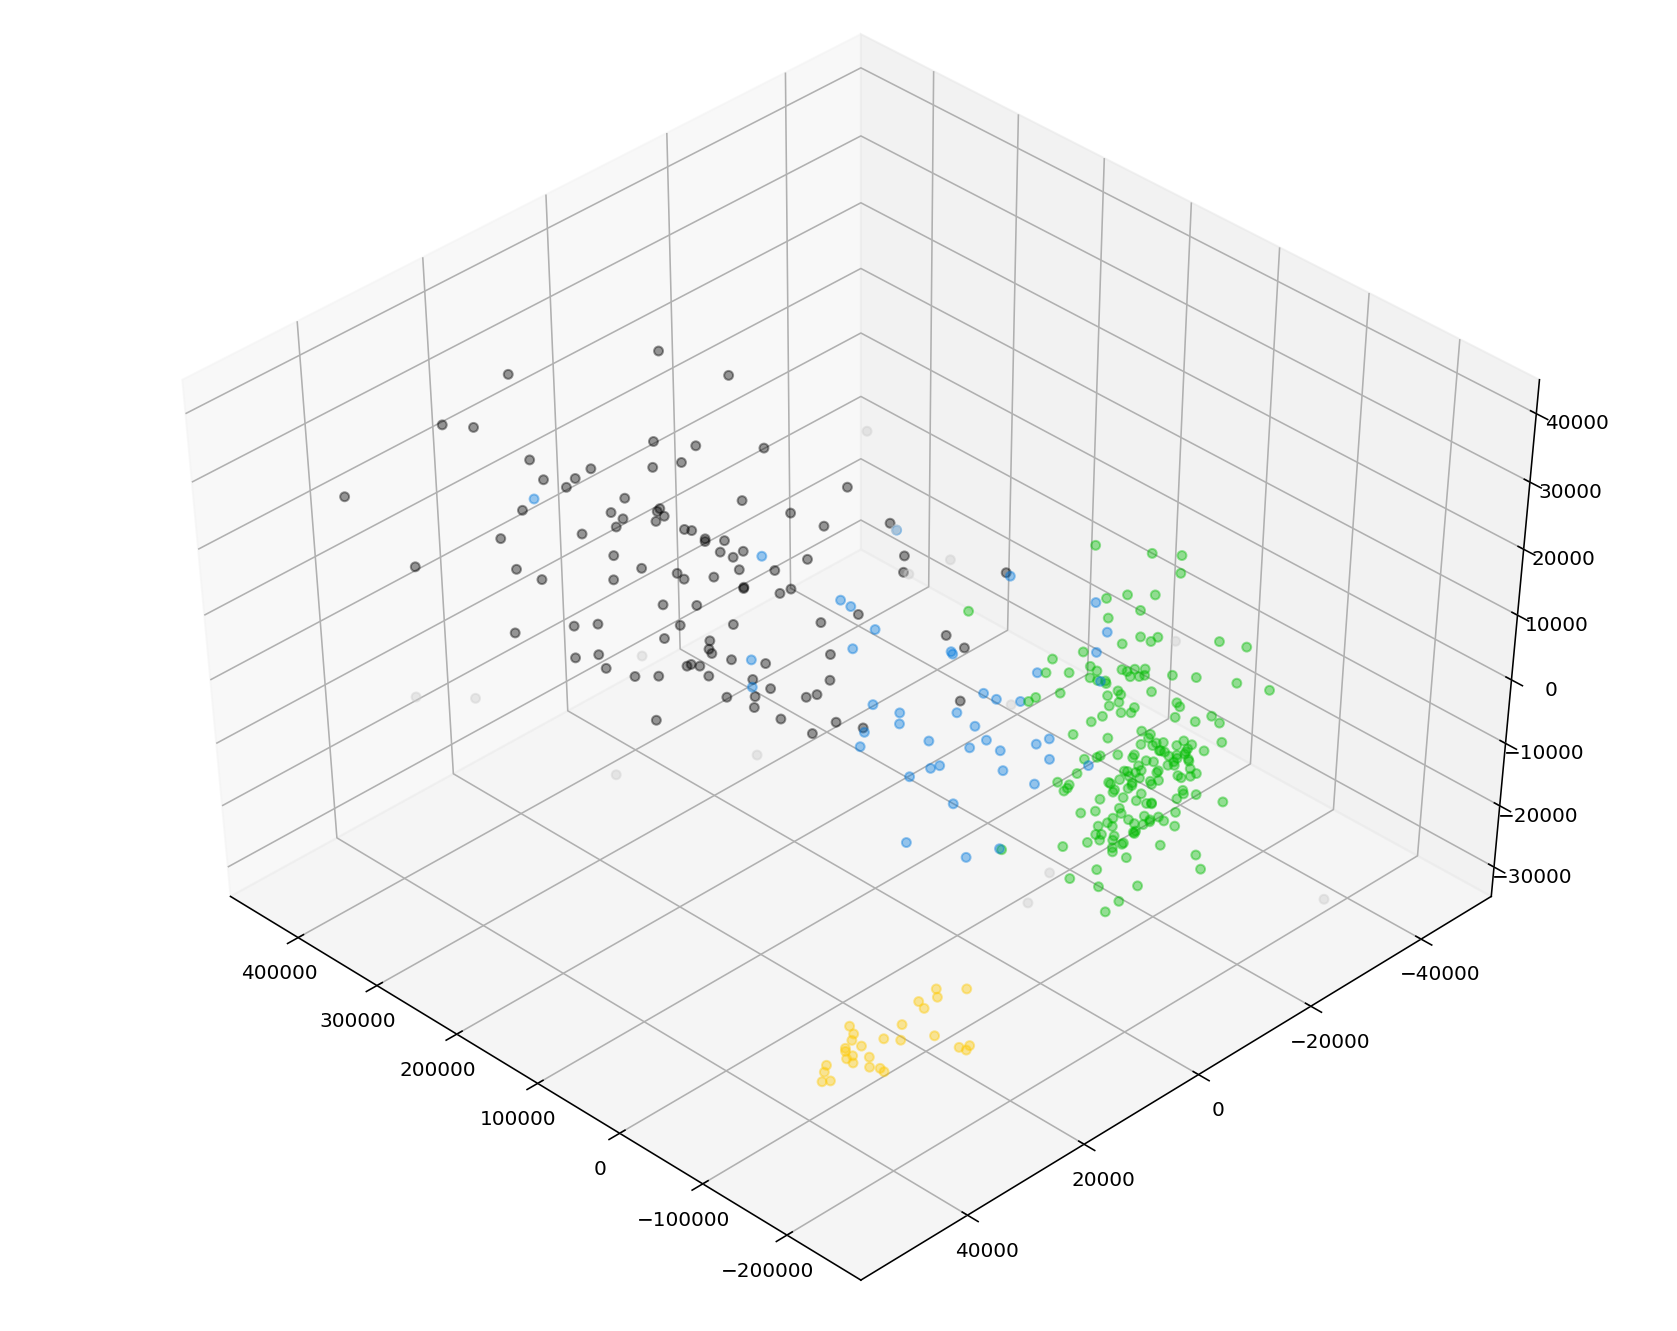

In [3]:
data = import_data()
data= np.array(data)
data= data.reshape(-1,24)

daydata= df(data)
daydata.index= pd.date_range('2014-1-1', periods=365, freq='D')

clusters= np.loadtxt('../data/Mixed_4_Clusters',delimiter=',')

pca= PCA(n_components=3)
pca.fit(daydata)
data_pca =  pca.transform(daydata)

# pdClusters= pd.DataFrame(clusters,index=daydata.index)
print(clusters)



fig = plt.figure(1, figsize=(12, 9))

ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=45, azim=135)

dayofweek = pd.DatetimeIndex(daydata.index).dayofweek

ax.scatter(data_pca[:,0],data_pca[:,1],data_pca[:,2],cmap=plt.cm.spectral,c=clusters,alpha= 0.4)

plt.show()


daydata['cluster']=clusters

In [8]:
def create_Train_GP_RBF_Model(inputx1,outputx1,n_features,RBFInputs=None,alpha=None,whiteKernel=None,n_restarts=None):
    
    if alpha is None: alpha = 0
    if RBFInputs is None: RBFInputs = 3
    if n_restarts is None: n_restarts = 5
    if whiteKernel is None: whiteKernel = False
        
    architecture=((n_features, 1, 2),)
    kernel_nn = C(1.0, (1e-10, 100)) \
    * ManifoldKernel.construct(base_kernel=RBF(0.1, (1.0, 100.0)),
                               architecture=architecture,
                               transfer_fct="tanh", max_nn_weight=1.0) \
    + WhiteKernel(1e-3, (1e-10, 1e-1))
    gp_nn = GaussianProcessRegressor(kernel=kernel_nn, alpha=0,
                                 n_restarts_optimizer=3)

    print('===========================================================================')
    print('\t \t Model has been successefully created and so being trained')
    print('===========================================================================')
    # Gaussian Process with Manifold kernel (using an isotropic RBF kernel on
    # manifold for learning the target function)
    # Use an MLP with one hidden-layer for the mapping from data space to manifold
    
    gp_nn.fit(inputx1, outputx1)
    
    plt.figure(figsize=(8, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(outputx1, gp_nn.predict(inputx1), c='b', label="GP RBF")
    # plt.scatter(y_test, gp_nn.predict(X_nn_test), c='r', label="GP NN")
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.legend(loc=0)
    plt.title("Scatter plot on test data")

    # print "RMSE of stationary anisotropic kernel: %s" \
    #     % mean_squared_error(y_test, gp.predict(X_nn_test))
    print "RMSE of stationary anisotropic kernel: %s" \
        % mean_squared_error(outputx2, gp_nn.predict(inputx2))

    plt.subplot(1, 2, 2)
    plt.xlabel("Manifold dimension 1")
    plt.ylabel("Manifold dimension 2")
    plt.title("Learned 2D Manifold")
    plt.show()
    
    print('==============================================================================')
    print('\t \t Gaussian process is ready for forecasting')
    print('==============================================================================')
    
    return gp_nn

def getForecastingResults(learninginputs,learningoutputs,testinputs,testoutputs,Model, nbrInputs, IsShift,previoushour,season):
    
    predictionPeriod = learninginputs.index.size-168
    temp=learninginputs.iloc[:predictionPeriod-24].resample('D').sum()
    temp= temp.dropna()
    temp2=learninginputs.iloc[:predictionPeriod-24]


    LearningForecastingError=pd.DataFrame(np.random.randn((predictionPeriod)/24-1, 1))

    learningInputs= learninginputs.iloc[:learningoutputs.index.size-168].copy()
    learningOutputs= learningoutputs.iloc[:learningoutputs.index.size-168].copy()
    LearningInputs_24= learninginputs.iloc[:learninginputs.index.size-168].copy()

    LearningHourlyError=pd.DataFrame(np.random.randn((predictionPeriod-24), 1))

    LearningDailyForecast=pd.DataFrame(np.random.randn((predictionPeriod-24), 2),index= temp2.index)
    LearningHourlyForecast=pd.DataFrame(np.random.randn((predictionPeriod-24), 2),index= temp2.index)


    print('==============================================================================')
    print('\t \t learning subset results')
    print('==============================================================================')

    for y in range(0,predictionPeriod/24-1):

        
        dailyError = 0

        for x in range(0,24):

            ####    hourly forecasting (get hourly error) 
            if IsShift == True:
                hourlyForcast= Model.predict(learningInputs.iloc[x + (y * 24) +1].reshape(-1,nbrInputs))
            else :
                hourlyForcast= Model.predict(learningInputs.iloc[x + (y * 24)].reshape(-1,nbrInputs))

            HourlyError = np.abs(((learningOutputs.iloc[x + (y * 24),0] - hourlyForcast[0]) / 
                                              learningOutputs.iloc[x + (y * 24),0]))
            LearningHourlyError.iloc[x + (y * 24)]= HourlyError
            
            LearningHourlyForecast.iloc[x + (y * 24),0]= hourlyForcast
            LearningHourlyForecast.iloc[x + (y * 24),1]= learningOutputs.iloc[x + (y * 24),0]

            if IsShift == True:
                Testforecast=Model.predict(LearningInputs_24.iloc[x + (y * 24) + 1].reshape(-1,nbrInputs))
                forecast=Model.predict(learningInputs.iloc[x + (y * 24) + 1].reshape(-1,nbrInputs))
            else :
                Testforecast=Model.predict(LearningInputs_24.iloc[x + (y * 24)].reshape(-1,nbrInputs))
                forecast=Model.predict(learningInputs.iloc[x + (y * 24)].reshape(-1,nbrInputs))
                
            dailyError = dailyError + np.abs(((learningOutputs.iloc[x + (y * 24),0] - Testforecast[0]) / 
                                              learningOutputs.iloc[x + (y * 24),0]))
            LearningDailyForecast.iloc[x + (y * 24),0]= Testforecast
            LearningDailyForecast.iloc[x + (y * 24),0]= learningOutputs.iloc[x + (y * 24),0]
            
            if previoushour == True: 
                if IsShift == True: 
                    if x + 2 < 24: LearningInputs_24.iloc[(x + (y * 24)) + 2,0] = forecast[0]
                else :
                    if x + 1 < 24: LearningInputs_24.iloc[(x + (y * 24)) + 1,0] = forecast[0]


        dailyError = (dailyError / 24) * 100

        LearningForecastingError.iloc[y,0] = dailyError

    HourlyLearningMAPE = LearningHourlyError.mean()
    print('Hourly Learning mean absolute percentage error of %d samples : %f ' %(LearningHourlyError.shape[0] , HourlyLearningMAPE[0]))


    LearningMAPE = LearningForecastingError.mean()
    print('Daily Learning mean absolute percentage error: %f ' %LearningMAPE[0])
    
    print('==================================================================================')
    print('\t \t MAPError plot through Learning DataSet ')
    print('==================================================================================')
    
    fig = plt.figure(figsize=(12,3))
    plt.plot(LearningForecastingError,label='Error')
    plt.show()
    
    dstart= testinputs.index[0]
    dstarti= 0
    dend= testinputs.index[testinputs.index.size-2]
    dendi= testinputs.shape[0]-2
    dend2= testinputs.index[testinputs.index.size-1]
    dend2i= testinputs.shape[0]-1

    testperiod=len(pd.date_range(dstart,dend,freq='H'))


    forecasting_history=pd.DataFrame(np.random.randn(dendi, 2),columns=['real', 'forecast'])

    validationInputs= testinputs.iloc[dstarti:dend2i,:].copy()
    validationOutputs= testoutputs.iloc[dstarti:dendi,:].copy()

#     for x in pd.date_range('%s'%dstart,'%s'%dend,freq='H'):
    for x in range(dstarti,dendi):
        if IsShift == True:
            forecast=Model.predict(validationInputs.iloc[x + 1].reshape(-1,nbrInputs))
        else :
            forecast=Model.predict(validationInputs.iloc[x + 0].reshape(-1,nbrInputs))
        
        forecasting_history.iloc[x,0]= forecast[0][0]
        forecasting_history.iloc[x,1]= testoutputs.iloc[x,0]
        
#         if previoushour == True: 
#             if IsShift == True:
#                 if (pd.Timedelta(x-(x + pd.DateOffset(hours=2))).seconds/3600) + 1 < 168 - 1: 
#                     validationInputs.loc[x + pd.DateOffset(hours=2),0] = forecast[0]
#             else :
#                 if (pd.Timedelta(x-(x + pd.DateOffset(hours=1))).seconds/3600) + 1 < 168 - 1: 
#                     validationInputs.loc[x + pd.DateOffset(hours=1),0] = forecast[0]
        if previoushour == True: 
            if IsShift == True:
                if ((x + 2)) + 1 < 168 - 1: 
                    validationInputs.iloc[x + 2,0] = forecast[0]
            else :
                if ((x +1)) + 1 < 168 - 1: 
                    validationInputs.iloc[x + 1,0] = forecast[0]




    testRMSS = rmse(forecasting_history.iloc[:,0], forecasting_history.iloc[:,1])
    testMAPE= mean_absolute_percentage_error(forecasting_history.iloc[:,0], forecasting_history.iloc[:,1])
    
    print('==================================================================================')
    print('\t \t Test subset results')
    print('==================================================================================')


    print('Test mean squared error: %f' %testRMSS)
    print('Test mean absolute percentage error: %f ' %testMAPE)


    print('==================================================================================')
    print('\t \t Validation Forecasting visualisation')
    print('==================================================================================')
    fig = plt.figure(figsize=(12,4))
    plt.plot(forecasting_history[:dendi], label=['real','forecast'])
    plt.legend(labels=['real','forecast'],loc= 'best')
    plt.show()
    
    return LearningMAPE, testMAPE, HourlyLearningMAPE, LearningDailyForecast, LearningHourlyForecast

In [6]:
season = 3
epoch = 100


UsedInputList = []
ModelsList = []
MAPErrorList = []
ForecastingList = []
Models_IDs = []
Models_parameters = []
Model_ID = 0

	 	 learning subset results


/Users/mac/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:85: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/mac/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:98: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/mac/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:99: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


Hourly Learning mean absolute percentage error of 336 samples : 0.061043 
Daily Learning mean absolute percentage error: 6.954162 
	 	 MAPError plot through Learning DataSet 


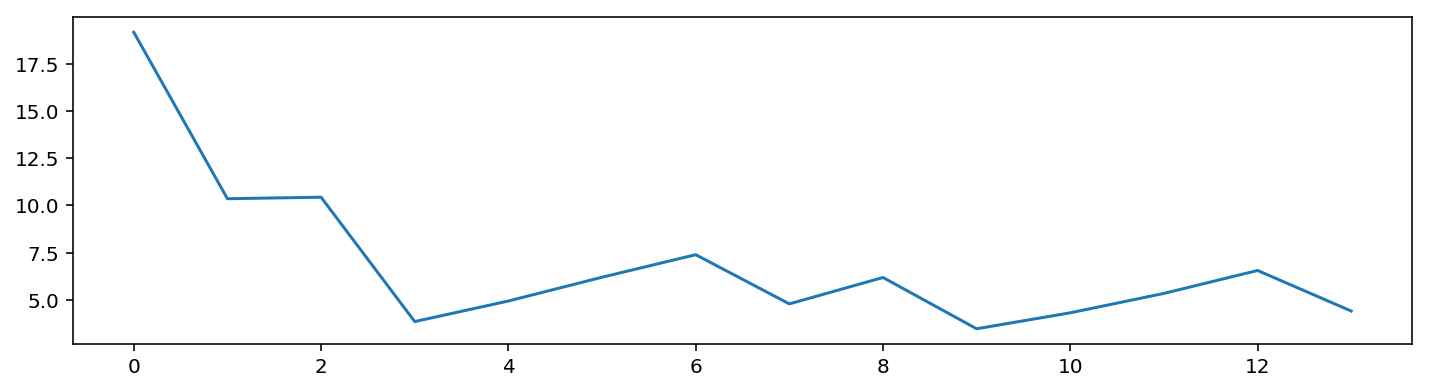

/Users/mac/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:152: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


	 	 Test subset results
Test mean squared error: 0.007237
Test mean absolute percentage error: 6.856108 
	 	 Validation Forecasting visualisation


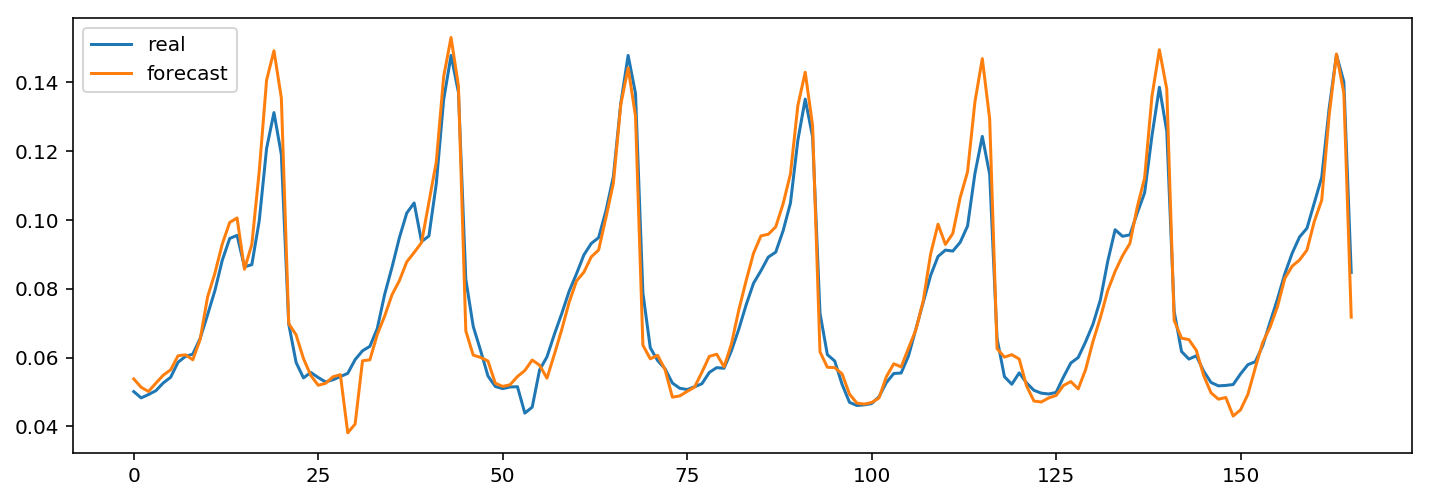

	 	 Forecasting a sample from Learning dataset


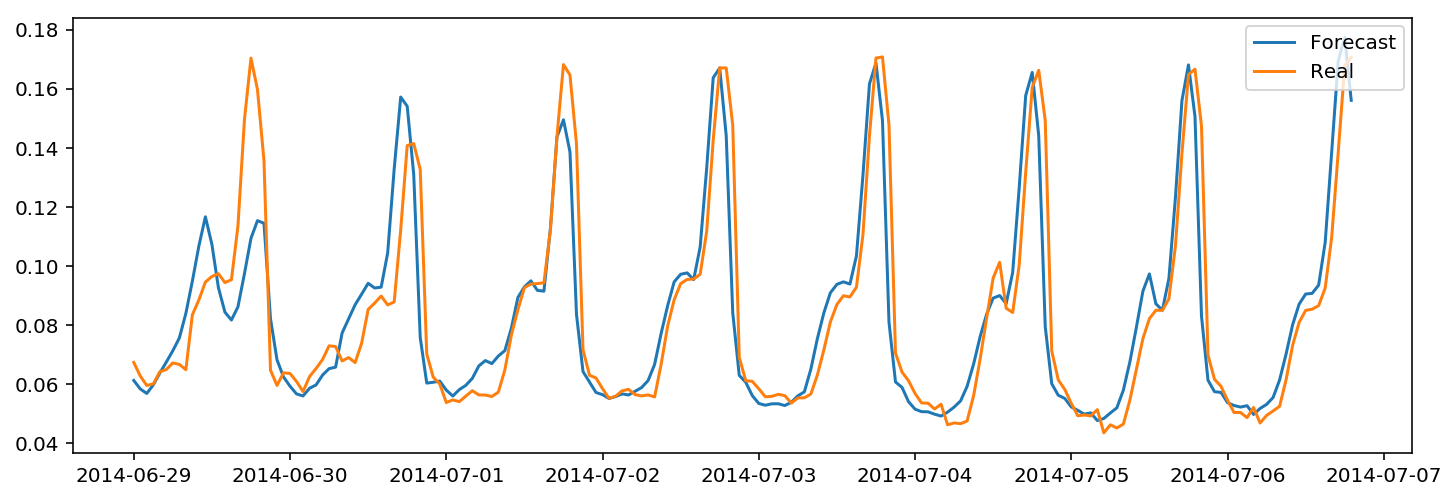

In [11]:
# UsedInputsTemp= np.empty([7],dtype=bool)
# FinalErrorTemp= np.empty([2])
# Parameters = np.empty([3])
# ID= np.empty([1])
# ID[0]=Model_ID


# UsedInputsTemp[0] = previoushour = True
# UsedInputsTemp[1] = previousDay = True
# UsedInputsTemp[2] = previousWeek = True
# UsedInputsTemp[3] = Temp = True
# UsedInputsTemp[4] = TempMax = True
# UsedInputsTemp[5] = TempMin = True
# UsedInputsTemp[6] = dayIndicator = True

# shift = False

# learninginputs, learningoutputs, testinputs, testoutputs, nbrInputs = prepareInputs(daydata,season,UsedInputsTemp)
# #learning vectors
# inputx1 = np.array(pd.DataFrame(learninginputs.copy())).reshape(-1,nbrInputs)
# outputx1 = np.array(pd.DataFrame(learningoutputs.copy()))

# #test vectors
# inputx2 = np.array(pd.DataFrame(testinputs.copy())).reshape(-1,nbrInputs)
# outputx2 = np.array(pd.DataFrame(testoutputs.copy()))


# Parameters[0]= RBFInputs = 3
# Parameters[1]= Alpha = 0.01
# Parameters[2]= n_restarts = 3

# GP_Model = create_Train_GP_RBF_Model(inputx1,outputx1,nbrInputs,RBFInputs = RBFInputs
#                                                 ,alpha = Alpha,whiteKernel = True,n_restarts = n_restarts)

# clear_output()

LearningMAPE, testMAPE , LearningHourlyMAPE, LearningHourlyForecast, LearningDailyForecast  = getForecastingResults(
    learninginputs,learningoutputs,testinputs,testoutputs,GP_Model,nbrInputs,False,previoushour,season)
FinalErrorTemp[0] = LearningMAPE
FinalErrorTemp[1] = testMAPE

# UsedInputList.append(UsedInputsTemp)
# MAPErrorList.append(FinalErrorTemp)
# ModelsList.append(GP_Model)
# ForecastingList.append(LearningDailyForecast)
# Models_IDs.append(ID)
# Models_parameters.append(Parameters)
# Model_ID = Model_ID + 1

print('==================================================================================')
print('\t \t Forecasting a sample from Learning dataset')
print('==================================================================================')
plt.figure(figsize=(12,4))
plt.plot(ForecastingList[0].iloc[0:188,0],label='Forecast')
plt.plot(ForecastingList[0].iloc[0:188,1],label='Real')
plt.legend( loc=1, borderaxespad=0.4)
plt.show()


